


# *Data Science Unit 4 Sprint 2 Assignment 4*

Continue to use TensorFlow Keras & a sample of the [Quickdraw dataset](https://github.com/googlecreativelab/quickdraw-dataset) to build a sketch classification model. The dataset has been sampled to only 10 classes and 10000 observations per class. Apply regularization techniques to your model. 

**Don't forget to switch to GPU on Colab!**


## Objectives 

In lecture, you were exposed to several regularization techniques: Lp space regularization, Max Norm weight constraints, and dropout regularization.

1: Explore the effects of these regularization techniques on model performance and on the learned model weights. 

2: Review how to save a model and how to retrieve the saved model from a file.





#### Import libraries

In [7]:
# native libraries 
import os
from time import time 

# data analysis libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# deep learning libraries 
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import ReLU
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.utils import get_file



# regularizers 
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.constraints import MaxNorm

# required for compatibility between sklearn and keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# native python unit test library
from unittest import TestCase

%matplotlib inline

-----
# Part 1: GridSearch Experiments 

The next set of experiments will involve gridsearching regularization parameter values. 

The rest of the notebook will actually require very little coding on your part. Instead, the focus is for you to run those gridsearches and answer the questions at the end of each experiment. Those questions are designed to help you capture the insights that there are to learn from each of the experiments. 

All of the following experiments are designed to help you better understand the relationship between the various regularization techniques and how they affect model performance. 


### Build Model

Let's build out the model that we'll be using all throughout our experiments. 

Remember that **the whole point of regularization is to prevent overfitting.**


![](https://hackernoon.com/hn-images/1*vuZxFMi5fODz2OEcpG-S1g.png)

Overfitting happens when our models are too complex, so in order to see a benefit from the use of regularization techniques we need to build a relatively complex model. 

Having said that, you might not have the computational resource to be able to train a complex model in a reasonable amount of time. So if this describes you, then you might want to consider using `build_simple_model`. Otherwise, use `build_complex_model`. 

In this notebook, we'll use  `build_complex_model` to run our experiments. 

**NOTE:** Whichever function you end up using to build a model, take time to read through the code and make sure you understand what is happening. 

### Load the `quickdraw10` data set
using code provided in the Module 3 assignment.

In [8]:
def load_quickdraw10(cached=False):
    """
    Loads the normalized quickdraw10 imageset into shuffled train, test arrays
    
    Parameters
    ----------
    cached: bool (default False)
        set whether to load from remote url site or local root folder
    Returns
    ----------
    X_train, X_test, y_train, y_test: numpy arrays
    """
    
    if not cached:
        URL_ = "https://github.com/LambdaSchool/DS-Unit-4-Sprint-2-Neural-Networks/blob/main/quickdraw10.npz?raw=true"
        datapath = tf.keras.utils.get_file('./quickdraw10.npz', origin=URL_, extract=False)
    else:
        datapath = "../quickdraw10.npz"

    data = np.load(datapath)
    
    # normalize the image data
    max_pixel_value = 255
    X = data['arr_0']/max_pixel_value
    Y = data['arr_1']
        
    return train_test_split(X, Y, shuffle=True, test_size=0.1, random_state=42)

In [9]:
X_train, X_test, y_train, y_test = load_quickdraw10(cached=True)

### Build the model

In [10]:
def build_complex_model(Lp_reg=None, reg_penalty=None, dropout_prob=0.0, maxnorm_wc=None):
    """
    Build and return a regularized 3 hidden layer FCFF model 
    
    Parameters
    ----------
    Lp_reg: None or object
        If object, Lp_reg is either l1 or l2 regularization 
        If None, that means that l1 or l2 regularization will not be used.
     
    reg_penalty: None or float
        If float, reg_penalty is a value typically between 1.0 and 0.0001
        This is the regularization strength for l1 or l2 
        
        
    dropout_prob: float
        This is the probability that dropout regularization will exclude a node from a training iteration. 
        If this value is 0.0, that means that dropout will not be used. 
        
    maxnorm_wc: None or float
        If float, maxnorm_wc is the weight constraint that is used for Max Norm regularization
        If None, that means that Max Norm regularization will not be used.
        
        
    Return
    ------
    model: compiled Keras model
    """

    # specify the input size
    input_dim = 784

    # specify the number of neurons in the output layer
    n_output = 10

    # if reg_type is not None, then pass in the penalty strength to whatever form of Lp space regularization this is 
    if Lp_reg is not None:
        Lp_regularizer = Lp_reg(reg_penalty)
    else:
        Lp_regularizer = None
                
    if maxnorm_wc is not None:
        wc = MaxNorm(max_value=maxnorm_wc)
    else:
        wc = None


    # instantiate Sequential class
    model = Sequential([    

    # hidden layer 1
    Dense(500, kernel_regularizer=Lp_regularizer , kernel_constraint=wc, input_dim=input_dim), # remember that Keras refers to weight matrix as a kernel, i.e. weights = kernel
    # act func 1
    ReLU(negative_slope=0.01),
    Dropout(dropout_prob),

    # hidden layer 2
    Dense(250, kernel_regularizer=Lp_regularizer, kernel_constraint=wc),
    # act func 2
    ReLU(negative_slope=0.01),
    Dropout(dropout_prob),

    # hidden layer 3
    Dense(100, kernel_regularizer=Lp_regularizer, kernel_constraint=wc),
    # act func 3
    ReLU(negative_slope=0.01),
    Dropout(dropout_prob),

    # output layer   
    Dense(n_output, activation="softmax")  

    ])
    # compile model 
    model.compile(loss="sparse_categorical_crossentropy", 
                 optimizer="adam", 
                 metrics=["accuracy"])
    
    return model

Again, only use `build_simple_model` instead of `build_complex_model` if you're working on a machine with very limited computational resources. 

In [ ]:
# def build_simple_model(Lp_reg=None, reg_penalty=None, dropout_prob=0, maxnorm_wc=None):
#     """
#     Build and return a regularized 1 hidden layer FCFF model 
    
#     Parameters
#     ----------
#     Lp_reg: None or object
#         If object, Lp_reg is either l1 or l2 regularization 
#         If None, that means that l1 or l2 regularization will not be used.
     
#     reg_penalty: None or float
#         If float, reg_penalty is a value typically between 1.0 and 0.0001
#         This is the regularization strength for l1 or l2 
        
        
#     dropout_prob: float
#         This is the probability that dropout regularization will exclude a node from a training iteration. 
#         If this value is 0.0, that means that dropout will not be used. 
        
#     maxnorm_wc: None or float
#         If float, maxnorm_wc is the weight constraint that is used for Max Norm regularization
#         If None, that means that Max Norm regularization will not be used.
        
        
#     Return
#     ------
#     model: compiled Keras model
#     """

#    # specify the input size
#    input_dim = # YOUR CODE HERE

#    # specify the number of neurons in the output layer
#    n_output = # YOUR CODE HERE

#     if Lp_reg is not None:
#         Lp_regularizer = Lp_reg(reg_penalty)
#     else:
#         Lp_regularizer = None

#     # instantiate Sequential class
#     model = Sequential([

#     # hidden layer 1
#     Dense(128,  kernel_regularizer=Lp_regularizer, kernel_constraint=maxnorm_wc, input_dim=input_dim), # remember that Keras refers to weight matrix as a kernel, i.e. weights = kernel
#     # act func 1
#     ReLU(negative_slope=0.01),
#     Dropout(p_dropout),

#     # output layer   
#     Dense(n_output, activation="softmax")  

#     ])
#     # compile model 
#     model.compile(loss="sparse_categorical_crossentropy", 
#                  optimizer="adam", 
#                  metrics=["accuracy"])
    
#     return model

Since we'll be using sklearn's `GridsearchCV` class, we need to wrap our Keras models in `KerasClassifier`

In [11]:
# wrap KerasClassifier around build_model for compatibility with sklearn GridsearchCV 
model = KerasClassifier(build_fn = build_complex_model)

<ipython-input-11-2d67b99a9966>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = build_complex_model)


-------

# Experiment 1: Identify the relationship between model performance and L2 penalty strength

![](https://www.researchgate.net/publication/334159821/figure/fig1/AS:776025558495234@1562030319993/Ridge-regression-variable-selection.png)

_Note: <br>
In the right panel of the above diagram, **SSE** <br>
stands for "Sum of Squared Errors".<br>
In the left panel, **ESS** is a typo that should read **SSE**._<br>

We are going to run a gridsearch solely on the L2 regularization penalty value and see the effect this has on model performance. 

By running a gridseach on only a single hyperparameter (while using the same data and model) we can isolate the effect of that hyperparameter. <br><br>


In [7]:
# build out our hyperparameter dictionary 
hyper_parameters = {
    # take note that Lp_reg penalty/strength values are in powers of 10 
    "reg_penalty": [10.0, 1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001], 
    # Since we only want to test l2, provide l2 as the sole option 
    "Lp_reg": [l2],
    # default is 1, in order to change it we must provide value here because we can't provide a parameter value for model.fit() directly when using gridsearch
    # protip: consider changing epochs to 1 if the gridsearch run-time is too long for you
    "epochs": [3] 
}

In [8]:
start=time()
# takes about 7 min on Colab with GPU
# Create and run Grid Search
grid = GridSearchCV(estimator=model, 
                    param_grid=hyper_parameters, 
                    n_jobs=-2, 
                    verbose=1, 
                    cv=3)

grid_result = grid.fit(X_train, y_train)
end=time()

Fitting 3 folds for each of 7 candidates, totalling 21 fits
Epoch 1/3
2813/2813 [==============================] - 25s 9ms/step - loss: 0.5952 - accuracy: 0.8235
Epoch 2/3
2813/2813 [==============================] - 23s 8ms/step - loss: 0.4343 - accuracy: 0.8757
Epoch 3/3
2813/2813 [==============================] - 24s 8ms/step - loss: 0.3733 - accuracy: 0.8954


In [9]:
print("Gridsearch runtime {0:.3} mins".format( (end-start)/60 ))

Gridsearch runtime 15.3 mins


Text(0.5, 0, 'L2 Penalty Strength usng a Log Scale')

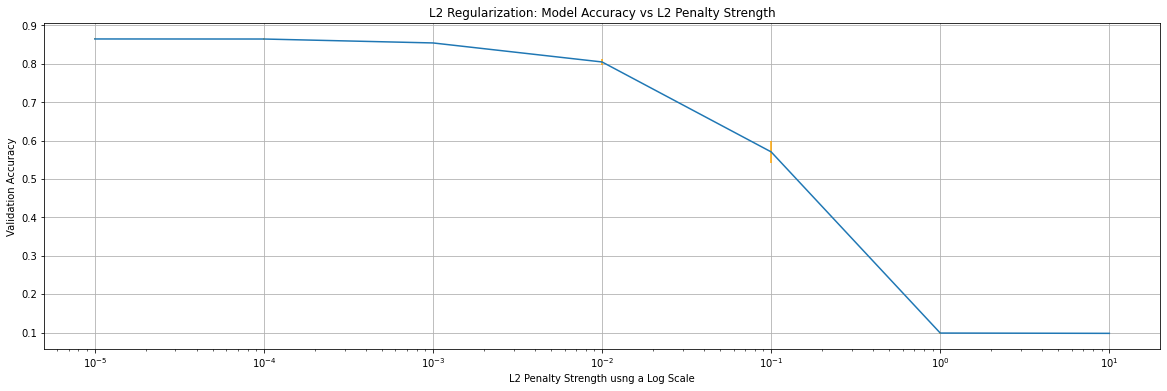

In [11]:
# use the mean accuracy from the CV splits for determining best model score 
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

# move l2 penalty values outside of dictionary and into a list
param_values = [param_dict["reg_penalty"] for param_dict in params]

# plot accuracy vs l2_reg_penalty
plt.figure(figsize=(20,6))
plt.grid()

# this plot is using the std of the CV splits to plot error bars however those values are so small that they aren't visable
plt.errorbar(param_values, means, yerr=stds, ecolor="orange")
plt.xscale("log") # use a log scale for ease of reading, recall that l2_reg_penalty were in powers of 10 
plt.title("L2 Regularization: Model Accuracy vs L2 Penalty Strength")
plt.ylabel("Validation Accuracy", )
plt.xlabel("L2 Penalty Strength usng a Log Scale")

### Observations

Write down some observations. What do you notice from the plot?

- Each order of magnitude increase in L2 penalty strength has an increased effect on validation accuracy; almost nochange at very low values and reducing accuracy to near zero at high magnitude


## Compare Weights between the Best Model and a Worse Model 

Next, we are going to compare the hidden layer weights between the best and worst performing model while taking note of the respective L2 penalty strengths.

In [12]:
# get the best l2 penalty term 
best_lr_penalty = grid_result.best_params_["reg_penalty"]

# get the best trained model
#     a model that is wrapped in the KerasClassifier wrapper doesn't have a .get_weights() method.
#     So this is the workaround to generate a version of the model that does have a .get_weights() method
best_model = grid_result.best_estimator_.build_fn(Lp_reg=l2, reg_penalty=best_lr_penalty)

# get the weights from the best trained model 
best_weights = best_model.get_weights()

In [13]:
# train a model using the l2_reg_penalty value that scored the lowest 
worse_l2_reg_penalty = 10.0

worse_model = build_complex_model(Lp_reg=l2, reg_penalty=worse_l2_reg_penalty)

# fit model 
worse_model.fit(X_train, y_train, epochs=1)

# get weights from worst performing model 
worse_weights = worse_model.get_weights()

2813/2813 [==============================] - 26s 9ms/step - loss: 93.3756 - accuracy: 0.1025


-----
## Understanding how Weights and Biases are stored

Let's take a minute to understand that`.get_weights()` returns a list with 8 elements (if you're using `build_complex_model`).

In [14]:
len(best_weights)

8

There are **weights matrices and bias vectors between each layer** and we have 5 layers. The last 4 layers are composed of neurons. 

- Input
- Hidden 1
- Hidden 2
- Hidden 3
- Output 

So we should have a weight matrix and a bias vector from each neuron layer, <br>which accounts for $4 + 4 = 8$ elements in the list.


#### Index for Weight Matrices 
If you index for a weight matrix, you can see its shape and that they are indeed matrices. 

Notice how you can see the dims of the layers that the matrices are sandwiched between?

The input layer has 784 dims and hidden layer 1 has 500 neurons. <br>
So the first weight matrix should have a column of weights for each neuron; and each column has 784 weights.
Given this understanding, the numbers you see in the shapes of the weight and bias arrays should make sense. 

In [15]:
# between input and 1st hidden layer
best_weights[0].shape

(784, 500)

In [16]:
# between 1st and 2nd hidden layer
best_weights[2].shape

(500, 250)

In [17]:
# between 2nd and 3rd hidden layer
best_weights[4].shape

(250, 100)

In [18]:
# between 3rd hidden layer and output layer
best_weights[6].shape

(100, 10)

#### Index for the bias vectors

The shapes of the bias vectors should exactly match up the dims/nodes of each layer (excluding the input layer). 

In [19]:
# for hidden layer 1 
best_weights[1].shape

(500,)

In [20]:
# for hidden layer 2 
best_weights[3].shape

(250,)

In [21]:
# for hidden layer 3
best_weights[5].shape

(100,)

In [22]:
# for output layer
best_weights[7].shape

(10,)

-----

### Back to our Analysis of L2 space regularization (also known as Ridge)

To gauge the performance effect of L2 regularization, we'll compare the weights for the 1st hidden layer from the best and worst performing models from our hyperparameter search space, as well as with the initial weight values that are randomly sampled from the GlorotUniform distribution.

[**Check out the Keras docs for the Dense layer**](https://keras.io/api/layers/core_layers/dense/), you'll see that GlorotUniform is the default weight initializer. 

Read the docs to figure out how to get the weights from a Keras dense layer.
Also have a look at this helpful post on StackOverflow: [**How to view initialized weights (i.e. before training)?**](https://stackoverflow.com/questions/46798708/how-to-view-initialized-weights-i-e-before-training)


Before we compare weights, let's take note of the following. 

Both `best_weights[0]` or `worse_weights[0]` are matrices with shape `(784, 500)`. 

If we flatten them, then we get `784 * 500 = 392000` weights. What does this mean exactly?

Remember that we are working with the Fully Connected Feed-Forward model which looks something like this. 

![](https://pyimagesearch.com/wp-content/uploads/2016/08/simple_neural_network_header.jpg)

In Fully Connected neural network models, the outputs from a layer become the inputs for the next layer. Each output from a layer is passed as an input to all the nodes in next layer.<br>
Our input layer has $784$ output weights which are the pixel values in the image. Each neuron (or node) in hidden layer $1$ also has $784$ weights, one for each pixel input.  Hidden layer 1 has $500$ neurons. So the weights are conveniently represented as a **weights matrix** with $784$ rows (one row for each pixel in the input image) and $500$ columns (one column for each neuron in the layer). The $i$th column of the weights matrix holds the $784$ weights $\textbf{w}_{i}$ belonging to the $i$th neuron in the layer.

To keep our analysis simple, we are going to analyze only the weights corresponding to the first neuron in hidden layer $1$, whose weights $\textbf{w}_{1}$ are the first column of the weight matrix.  <br><br>

We will observe the effect of L2 regularization on neuron 1 in hidden layer 1.


In [67]:
# index for the 1st column (784 entries) in the 1st hidden layer weights in best_weights and save to best_hidden_weights

# index for the 1st column (784 entries) in the 1st hidden layer weights in worse_weights and save to worse_hidden_weights

# Keras models randomly samples from the GlorotUniform distribution for the initial values of model weights 
# instantiate GlorotUniform and sample 784 weights and save to initial_weight_values

# Build a data frame with these 3 vectors as columns

# YOUR CODE HERE

best_hidden_weights = [weights[0] for weights in best_weights[0]] 

worse_hidden_weights = [weights[0] for weights in worse_weights[0]]

initializer = GlorotUniform(seed=42)
# extract sampled weights into 1d numpy array
initial_weight_values = initializer(shape=(1, 784)).numpy()
initial_weight_values = initial_weight_values[0]
#initial_weight_values


In [66]:
initial_weight_values.shape

(784,)

In [68]:
# move all weights to a dataframe for ease of analysis 
cols = ["best_hidden_weights", "worse_hidden_weights", "initial_weight_values"]
data = [best_hidden_weights, worse_hidden_weights, initial_weight_values]
df = pd.DataFrame(data=data).T
df.columns = cols


In [69]:
# check out the statistics for each weight column 
df.describe()

,best_hidden_weights,worse_hidden_weights,initial_weight_values
count,784.000000,7.840000e+02,784.000000
mean,0.000238,-7.370600e-08,-0.002716
std,0.039409,2.220620e-06,0.051988
min,-0.068273,-6.202191e-05,-0.087382
25%,-0.032956,-7.331925e-18,-0.050396
50%,0.001022,-2.287076e-37,-0.001155
75%,0.033265,4.834843e-18,0.042111
max,0.068335,4.316038e-06,0.087284


array([[<AxesSubplot:title={'center':'best_hidden_weights'}>,
        <AxesSubplot:title={'center':'worse_hidden_weights'}>],
       [<AxesSubplot:title={'center':'initial_weight_values'}>,
        <AxesSubplot:>]], dtype=object)

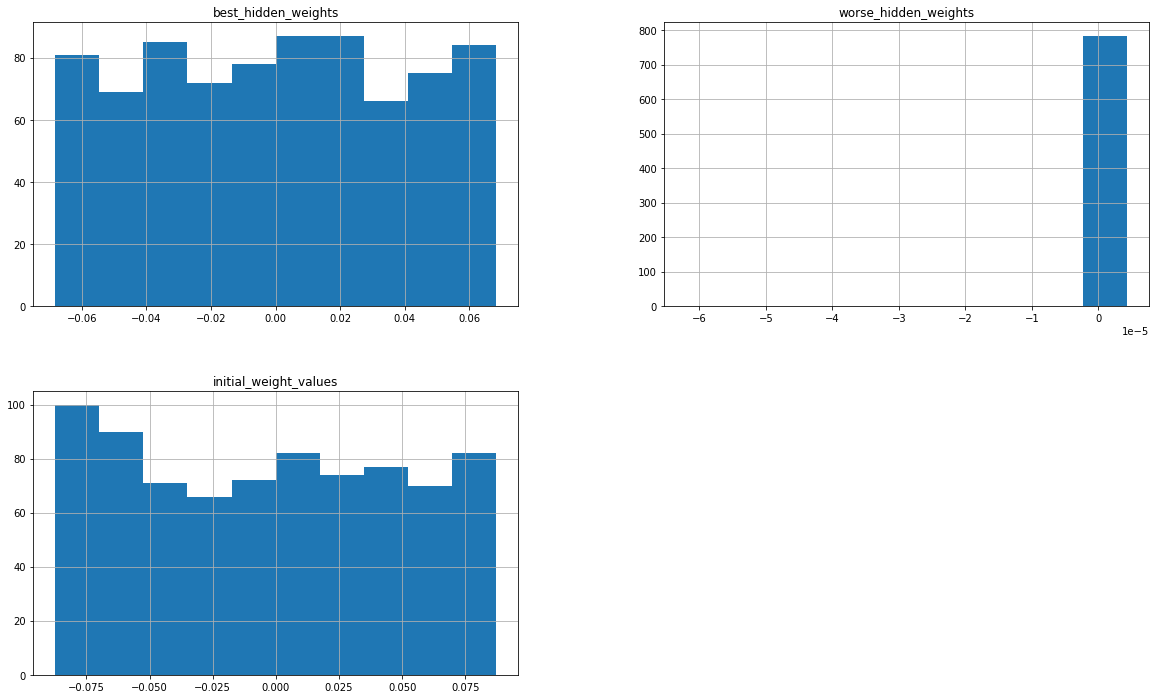

In [70]:
# plot the distributions for each weight column 
df.hist(figsize=(20,12))

## Observations 

Take a look at the statistical table and the plots. Then answer the following questions. 

**How do the hidden layer weights from the best performing model compare to the initial weight values?**

- The weights are distributed across a similar range of values

**What was the effect of using a small L2 penalty value (regularization constant)?**

 - The weights are not changes substantially from their initial, random values

**What was the effect of using a large L2 penalty value?**

- The final weights are all very small values

**Given what you know about L2 regularization, are you surprised by these results?**

- No, as L2 regularization works by imposing limits on the model weights, and high L2 regularization strength shrinks the allowed weight values exponentially

----

# Experiment 2: Identify the relationship between model performance and Max Norm Weight Constraint

![](https://qph.fs.quoracdn.net/main-qimg-9d0dbf8074761b541ba80543ddfc9f73.webp)

Recall from lecture that the **norm** of a vector is another word for the **length** of the vector.

`MaxNorm` weight constraint puts a limit on the norm of the weight vector.

The effect that Lp regularization and `MaxNorm` regularization have on the weights is similar, but they go about it in different ways. 

While Lp regularization (L1/Lasso and L2/Ridge) shrink the weight values by imposing constraints on their L1 and L2 norms, `MaxNorm` regularization shrinks the weight values by imposing a limit on the norm of a weight vector. Here's how it works: if an update would push the norm of a weight vector above MaxNorm, a scale factor is applied to all the weights so as to shrink the norm back to MaxNorm. 

In this experiment, we'll run another gridseach, similar to the one we ran for L2 regularization in the previous experiment. This time, we are going to gauge the effect of `MaxNorm` regularization on model performance and the distribution of the learned weights. As in the previous experiment, we will simplify our analysis by focusing on the weights for the first neuron in the first hidden layer.

Since we already built our model, we just need to update the `hyper_parameters` dictionary. 

In [71]:
# build out our hyperparameter dictionary 
hyper_parameters = {
    
    "maxnorm_wc": np.linspace(0.5, 10.0, num=20), 
    # default is 1, in order to change it we must provide value here because we can't provide a parameter value for model.fit() directly when using gridsearch
    # protip: consider changing epochs to 1 if the gridsearche run-time are too long for you    
    "epochs": [1] 
}

hyper_parameters

{'maxnorm_wc': array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,
         6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ]),
 'epochs': [1]}

In [72]:
start=time()
# Create and run Grid Search
grid = GridSearchCV(estimator=model, 
                    param_grid=hyper_parameters, 
                    n_jobs=-2, 
                    verbose=1, 
                    cv=3)

grid_result = grid.fit(X_train, y_train)
end=time()

Fitting 3 folds for each of 20 candidates, totalling 60 fits
2813/2813 [==============================] - 21s 7ms/step - loss: 0.5808 - accuracy: 0.8219


In [73]:
print("Gridsearch runtime {0:.3} mins".format( (end-start)/60 ))

Gridsearch runtime 13.2 mins


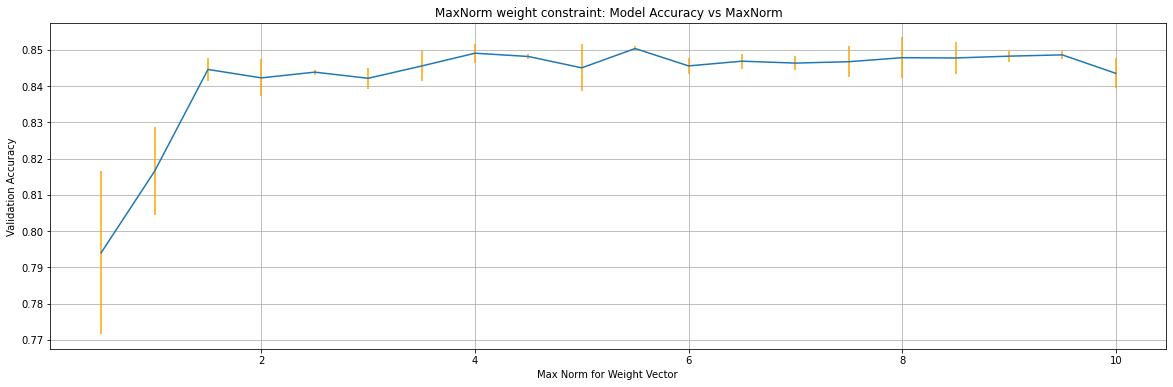

In [74]:
# use the mean accuracy from the CV splits for determining best model score 
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

# move l2 penalty values outside of dictionary and into a list
param_values = [param_dict["maxnorm_wc"] for param_dict in params]

# plot accuracy vs l2_reg_penalty
plt.figure(figsize=(20,6))
plt.grid()
plt.errorbar(param_values, means, yerr=stds, ecolor="orange")
plt.title("MaxNorm weight constraint: Model Accuracy vs MaxNorm")
plt.ylabel("Validation Accuracy", )
plt.xlabel("Max Norm for Weight Vector ");

In [78]:
# get the best value of max norm from grid and save to best_max_norm_val

# get the best trained model from grid and save to best_model

# get the weights from the best trained model and save to best_weights

# YOUR CODE HERE
# get the best maxnorm value
best_max_norm_val = grid_result.best_params_["maxnorm_wc"]

# get the best trained model
#     a model that is wrapped in the KerasClassifier wrapper doesn't have a .get_weights() method.
#     So this is the workaround to generate a version of the model that does have a .get_weights() method
best_model = grid_result.best_estimator_.build_fn()

# get the weights from the best trained model 
best_weights = best_model.get_weights()

In [79]:
best_max_norm_val

5.5

In [77]:
# we can verify that the norm of our weights are indeed below the maximum allowed value 
np.linalg.norm(best_weights[0][0])

0.8488284

In [80]:
# train a model using the max_norm_val value that scored the lowest 

# build a model using build_complex_model and worse_max_norm_val and save it to worse_model

# fit model 

# get weights from worse performing model 


# YOUR CODE HERE
#  value that scored the lowest 
worse_max_norm_val = 0.5

worse_model = build_complex_model(maxnorm_wc=0.5)

# fit model 
worse_model.fit(X_train, y_train, epochs=1)

# get weights from worst performing model 
worse_weights = worse_model.get_weights()

2813/2813 [==============================] - 20s 7ms/step - loss: 0.6835 - accuracy: 0.7880


Sample the initial weights from the `Glorot Uniform Weight Initializer`, for comparison

In [85]:
# index for the 1st hidden layer weights in best_weights and save to best_hidden_weights

# index for the 1st hidden layer weights in worse_weights and save to worse_hidden_weights

# Keras models randomly samples from the GlorotUniform distribution for the initial values of model weights 

# instantiate GlorotUniform and sample 500 weights and save to initial_weight_values
# hint: use shape=(1, 500)


# YOUR CODE HERE

best_hidden_weights = best_weights[0][0]

worse_hidden_weights = worse_weights[0][0]

initializer = GlorotUniform(seed=42)
# extract sampled weights into 1d numpy array
initial_weight_values = initializer(shape=(1, 500)).numpy()
initial_weight_values = initial_weight_values[0]
#initial_weight_values

In [86]:
len(best_hidden_weights)

500

In [87]:
# move all weights to a dataframe for ease of analysis 
cols = ["best_hidden_weights", "worse_hidden_weights", "initial_weight_values"]
data = [best_hidden_weights, worse_hidden_weights, initial_weight_values]
df_maxnorm= pd.DataFrame(data=data).T
df_maxnorm.columns = cols

In [88]:
df_maxnorm.describe()

,best_hidden_weights,worse_hidden_weights,initial_weight_values
count,500.000000,500.000000,500.000000
mean,0.003212,-0.000024,0.000505
std,0.040036,0.000950,0.061487
min,-0.068269,-0.005662,-0.108865
25%,-0.029040,-0.000103,-0.051220
50%,0.004349,0.000001,-0.000549
75%,0.037867,0.000076,0.051858
max,0.068340,0.010020,0.109024


array([[<AxesSubplot:title={'center':'best_hidden_weights'}>,
        <AxesSubplot:title={'center':'worse_hidden_weights'}>],
       [<AxesSubplot:title={'center':'initial_weight_values'}>,
        <AxesSubplot:>]], dtype=object)

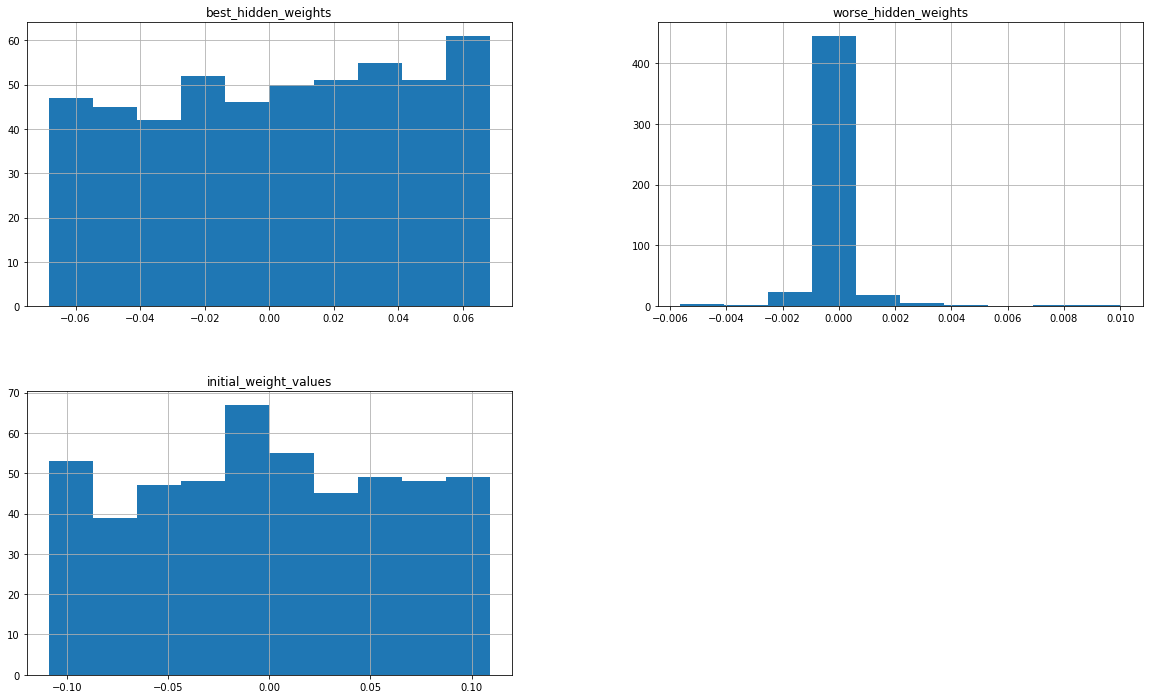

In [89]:
# plot the distributions for each weight column 
df_maxnorm.hist(figsize=(20,12))

## Observations 

Take a look at the statistical table and the plots. Then answer the following questions. 

**How do the hidden layer weights from the best performing model compare to the initial weight values?**

- The weights are in a slightly narrower, skewed distribution but still similar to the initial weight values

**What was the effect of using the weight constraint value in MaxNorm in the best performing model?**

- The weight constraint had almost no effect on the final weight values

**What was the effect of using the weight constraint value in MaxNorm in the worse performing model?**

- The weight constraint severely limited the distribution of final weight values to primarily near-zero values

**Given what you know about MaxNorm regularization, are you surprised by these results?**

- No, as extremly small values of weight constraints will limit the vector-length of the weights to very small values

-----
# Experiment 3: Identify the relationship between model performance and Dropout


![](https://miro.medium.com/max/981/1*EinUlWw1n8vbcLyT0zx4gw.png)

In the 3rd experiment, we will use gridsearch to see how varying the value of the the dropout probability affects model performance. 

Recall from lecture that dropout tends to perform best when used with `MaxNorm` regularization. Since this is the case, we will gridsearch both dropout probability and the weight constraint for `MaxNorm`. 

If interested, feel free to read (or just skim) through the original publication on [**Drop Out**](https://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf). 

**Key Take aways:** 

1. During training, dropout will probabilistically "turn off" some neurons in the layer that dropout is implemented in. 
2. During inference (ie. making predictions on the test set) all neurons are used (i.e. no dropout is applied).
3. Dropout works best when used with MaxNorm


In [90]:
# build out our hyperparameter dictionary 
hyper_parameters = {
    # for the sake of runtime, let's vary maxnorm_wc between 0.5 and 5.0
    "maxnorm_wc": np.linspace(0.5, 5, num=5),
    # take note that l1_reg_penalty values are in powers of 10 
    "dropout_prob": np.linspace(0.0, 0.6, num=5), 
    "epochs": [1] # default is 1, in order to change it we must provide value here because we can provide a parameter value for model.fit() directly when using gridsearch
}

hyper_parameters

{'maxnorm_wc': array([0.5  , 1.625, 2.75 , 3.875, 5.   ]),
 'dropout_prob': array([0.  , 0.15, 0.3 , 0.45, 0.6 ]),
 'epochs': [1]}

In [91]:
start=time()
# Create and run Grid Search
grid = GridSearchCV(estimator=model, 
                    param_grid=hyper_parameters, 
                    n_jobs=-2, 
                    verbose=1, 
                    cv=3)

grid_result = grid.fit(X_train, y_train)
end=time()

Fitting 3 folds for each of 25 candidates, totalling 75 fits
2813/2813 [==============================] - 25s 8ms/step - loss: 0.5816 - accuracy: 0.8225


In [92]:
print("Gridsearch runtime {0:.3} mins".format( (end-start)/60 ))

Gridsearch runtime 24.3 mins


In [93]:
# use the mean accuracy from the CV splits for determining best model score 
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']

Since there are 2 independent hyperparameters which affect the validation accuracy (`dropout_prob` and `maxnorm_wc`), <br> 
we need a two-dimensional plot. A heat map will work. 

In [94]:
dropout_prob_list = [  param_dict["dropout_prob"]  for param_dict in params]
maxnorm_wc_list = [  param_dict["maxnorm_wc"]  for param_dict in params]
data = [means, dropout_prob_list, maxnorm_wc_list ]

cols = ["val_acc", "dropout_prob", "maxnorm_wc"]
df_exp3 =pd.DataFrame(data=data).T
df_exp3.columns = cols
df_exp3.dropout_prob = df_exp3.dropout_prob.round(2)

# pivot dataframe in preparation for heat map
df_exp3 = df_exp3.pivot("maxnorm_wc", "dropout_prob", "val_acc")

<AxesSubplot:xlabel='dropout_prob', ylabel='maxnorm_wc'>

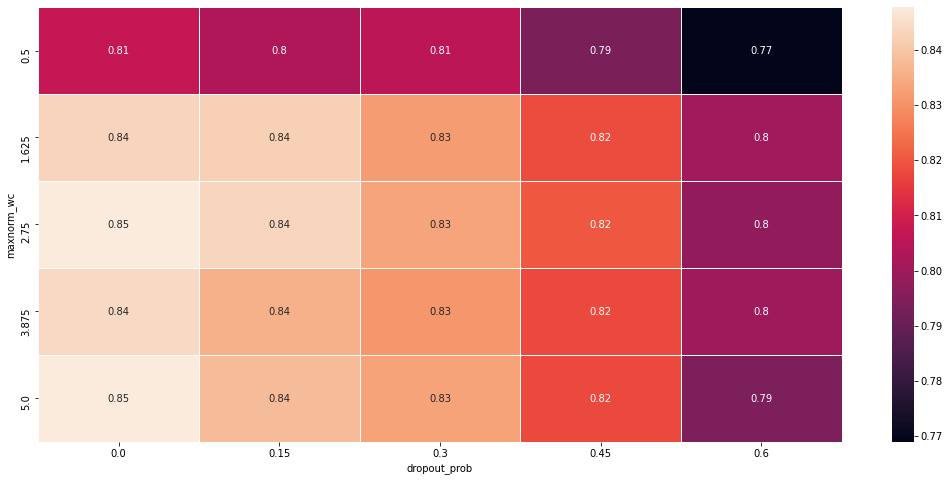

In [95]:
# Draw a heatmap with the val_acc values in each cell
f, ax = plt.subplots(figsize=(18, 8))
sns.heatmap(df_exp3, annot=True,  linewidths=.5, ax=ax)

### Observations 

We can see the dropout probabilities in the horizontal axis and the `MaxNorm` weight constraint values in the vertical axis. The values in the cells are the validation accuracy that corresponds to a pair of regularization values.

Take a look at the heat map and answer the following questions. Note that depending on which model you used (the simple or complex one) your answers might be different from that of others. 

**What range of dropout probability values tend to produce the highest validation accuracy?**

- The lowest probability values

**What range of maxnorm weight constraints tend to produce the highest validation accuracy?**

- The highest constraint values

**When taken together, what combinations of dropout probability and maxnorm weight constraints tend to produce the highest validation accuracy?**

- Dropout probability of ~0 and maxnorm weight of 0-2

**Do you think that using dropout was helpful in increasing model performance?**

- Inconclusive for the range of values tested

_____

#Part 2: Model Deployment
# Experiment 4: Train, Save, and Load a Keras model

Let's get some practice with how to save and load trained Keras models 

For this experiment, review the section on Saving and Loading models from the guided project, then: 

- Build a model of your choosing
- Gridsearch the model with a method of your choosing
- Save the trained model to a file
- Load the trained model from the file
- Just as we did in the Guided Project, evaluate the loaded model using a test set and verify that the results of the loaded model match that of the original model that was saved.

In [15]:
# generating quick gridsearch

hyper_parameters = {
    "maxnorm_wc": [0.5, 2, 5], 
    "dropout_prob": [0.2, 0.4, 0.6], 
    "epochs": [1]
}

# build and compile basic model
model = KerasClassifier(build_fn = build_complex_model)

# gridsearch and fit basic model
grid = GridSearchCV(estimator=model, 
                    param_grid=hyper_parameters, 
                    n_jobs=-2, 
                    verbose=1, 
                    cv=3)

grid_result = grid.fit(X_train, y_train)

<ipython-input-15-9369cf41c719>:10: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = build_complex_model)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
2813/2813 [==============================] - 26s 9ms/step - loss: 0.6687 - accuracy: 0.7963


In [17]:
# evalute model
model = grid_result.best_estimator_.build_fn()
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 2.3350 - accuracy: 0.0879


[2.335038661956787, 0.08789999783039093]

In [18]:
# Save the entire model as a SavedModel.
model.save('saved_models/saved_model')

INFO:tensorflow:Assets written to: saved_models/saved_model\assets


In [19]:
# Load the complete saved model
saved_model = tf.keras.models.load_model('saved_models/saved_model')

# Check that we retrieved the saved model architecture correctly
saved_model.summary()

# check that we get the original result using the saved weights
saved_model.evaluate(X_test, y_test)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 500)               392500    
                                                                 
 re_lu_6 (ReLU)              (None, 500)               0         
                                                                 
 dropout_6 (Dropout)         (None, 500)               0         
                                                                 
 dense_9 (Dense)             (None, 250)               125250    
                                                                 
 re_lu_7 (ReLU)              (None, 250)               0         
                                                                 
 dropout_7 (Dropout)         (None, 250)               0         
                                                                 
 dense_10 (Dense)            (None, 100)              

[2.335038661956787, 0.08789999783039093]